# Explainable ML: A peek into the black box through SHAP

#### Rework in progress

The insurance industry has always been more conservative when it comes to modelling, and with good reason. The financial and social impact of a wrongly predicted say, fraud detection model denying a policyholder’s entitlement to a claim is huge, and could lead to anti-discrimination allegations. Compare that to the impact of a wrongly predicted song recommendation pushed from your favourite music player’s machine learning algorithm. 

As a result of this, a considerable level of transparency is required to explain the basis of decisions made by models to various stakeholders. Apart from the professional standards, one could refer to the [information note](https://actuaries.logicaldoc.cloud/download-ticket?ticketId=85c37260-4721-4864-ae2b-24e043bef8ce) provide by the Data Analytics Working Group on the guidelines when considering the level of transparency required.

While GLMs offer this transparency and unambiguity of model results, it limits the model choice which may sometimes cause am issue when the underlying interactions are more complex, and we need a more complicated black-box model to accomodate this.

There are some tools and techniques available to explain individual (local) deicsions of a black box model in case of a need to manually review/ debug the model, and this might be sufficient to address explainable decisions for some applications. 

This article will go through SHAP, which is one of the aforementioned techniques available. Although this article will make use of the Python implementaion, there is also a R wrapper for the shap package called [shapper](https://github.com/ModelOriented/shapper), or ml3 which works with [DALEX](https://mlr-org.com/docs/mlr3-loves-dalex/). For more information on how to get started with DALEX, check out [Jacky Poon's top 10 R packages for data analysis](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/topten-r-packages/)


## Run this from your browser

The python code shown this snippet can be run from your browser through this [link](https://mybinder.org/v2/gh/jtsw1990/shap_article/HEAD).

Note that some loading time is to be expected, particularly when performing gridsearch and cross-validation for the machine learning models. However, the binder does not require the reader to download the dataset, or any other dependencies to run the models. Furthermore, the reader is encouraged to play around with the code and look at how SHAP explains the different predictions, as well as explore other graphs that the SHAP package has to offer.

## Tools and Packages

The example uses [Python3](https://www.python.org/downloads/release/python-379/) and the main packages that we will be using are listed below:

- [Shap](https://pypi.org/project/shap/) for model validation
- [Matplotlib](https://pypi.org/project/matplotlib/) for visualisation as shap graphs uses it as a backend
- [Pandas](https://pypi.org/project/pandas/) and [Numpy](https://pypi.org/project/numpy/) for general data manipulation
- [Sci-kit learn's](https://pypi.org/project/scikit-learn/) pipeline framework and machine learning algorithms

Note that the sklearn pipeline is the main backbone of the process here out of convenience but any other workflow/ preprocessing framework would work just as well.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor

warnings.filterwarnings('ignore')
plt.ioff()

from IPython.display import Image
from IPython.core.display import HTML 

## Importing, Preprocessing, Modelling

The dataset used in this article includes some policyholder information as follows: 

- **age**: Policyholder age (_integer_)
- **sex**: Gender of the policyholder (_string_)
- **bmi**: Body mass index (_float_)
- **children**: Number of children/ dependents of policyholder (_integer_)
- **smoker**: Smoking state of policyholder (_string_)
- **region**: Residential area of the policyholder in the US (_string_)

As well as a **claims cost** response column. The data can be downloaded from the github repository [here](https://github.com/sharmaroshan/Insurance-Claim-Prediction).


Note that although all the usual steps in the modelling process are involved here, this article will mainly focus on using the SHAP package and interpreting the model predictions. With that in mind, the rest of this section will not be covered in detail, but includes:
- Importing the data
- Splitting the dataset into training and testing sets
- Creating a "preprocessor" step to one-hot-encode categorical features
- Building a sklearn pipeline with the preprocessing and a GBM Regressor model
- Performing gridsearch and cross-validation for the GBM model to get the "best" set of hyperparameters
- 2 very brief/high-level checks to ensure that:
    - Nothing has gone terribly wrong in the model and we are in the ballpark in terms of predictions
    - We have not grossly overfitted on the training set

#### Importing

In [2]:
# Import data from GitHub repository
df = pd.read_csv("https://raw.githubusercontent.com/sharmaroshan/Insurance-Claim-Prediction/master/insurance.csv")

# Get column names for independent and response variables
rating_factors_col = list(df.columns[:-1])
claims_col = df.columns[-1]

In [3]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [4]:
# Splitting up the categorical columns and numerical columns
# This is to differentiate the preprocessing steps applied later in the pipeline

num_features = list(df[rating_factors_col].select_dtypes(include=["int64", "float64"]).columns)
cat_features = [col for col in rating_factors_col if col not in num_features]

#### Preprocessing

In [5]:
# Split our dataset into training and testing sets. Using 20/80 split here.

X_train, X_test, y_train, y_test = train_test_split(
            df[rating_factors_col],
            df[claims_col],
            test_size=0.2,
            random_state=123
        )

In [6]:
# Create a preprocessor step
# This ignores numerical columns but applies OHE to categorical features

preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", "passthrough", num_features),
        ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"), cat_features)
    ]
)

In [7]:
# Some wrangling done to get OHE feature names
# Note that XXXX method can be used as well

ohe_categories = preprocessor.fit(X_train).named_transformers_["categorical"].categories_
ohe_categories_concat = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
rating_factors_encoded = num_features + ohe_categories_concat

In [8]:
# Create a dictionary of hyperparameters to be optimised
# Create a sklearn Pipeline object which takes in the preprocessor step as well as a GBM object

param_grid = {
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__min_samples_leaf": [1, 3, 5],
    "model__min_samples_split": [2, 4],
    "model__n_estimators": [100, 200]
}

gbm_model = Pipeline([("preprocessor", preprocessor), ("model", GradientBoostingRegressor())])

#### Modelling: Gradient Boosted Machine

In [9]:
# Instantiate a gridsearch-cross validation object
# This takes in our previously created gbm pipeline and grid of hyperparameters to be tested
# Using a standard 5 part CV split with MSE as a score as we are doing a regression exercise

gs = GridSearchCV(
    gbm_model, 
    param_grid=param_grid, 
    n_jobs=-1, 
    cv=5, 
    scoring="neg_mean_squared_error",
    verbose=0
)

In [10]:
# Run the gridsearch, set the hyperparameters to the set which gave us the lowest MSE
# Fit the optimised model on our training data set and get test set predictions

_gs = gs.fit(X_train, y_train)

gbm_model.set_params(**gs.best_params_)
gbm_model.fit(X_train, y_train)
gbm_pred = gbm_model.predict(X_test)

#### Reasonableness checks

In [11]:
# Function created to create a mutliple bar chart comparing actual claims
# costs vs predicted claims costs split by deciles

def plot_avepp(df, expected, actual):
    avepp = df.assign(
        model_bands=pd.qcut(df[expected], 10, labels=np.arange(10) + 1),
    ).groupby("model_bands")[[expected, actual]].agg("sum").reset_index()
    n = avepp["model_bands"].max()
    width = 0.35
    ax = plt.subplot(111)
    pred_fig = ax.bar(np.arange(n) + width, avepp[expected], width)
    actual_fig = ax.bar(np.arange(n), avepp[actual], width)
    ax.set_title("AvE Decile Plot")
    ax.set_xticks(np.arange(n) + width / 2)
    ax.set_xticklabels(np.arange(n) + 1)
    ax.legend((pred_fig[0], actual_fig[0]), ("Pred", "Actual"))
    plt.show()

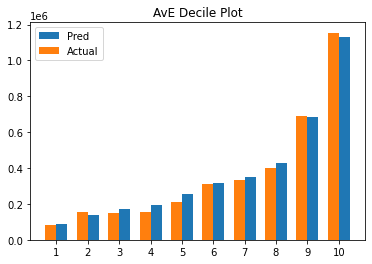

In [12]:
test_results = pd.concat(
    [
        X_test.reset_index(),
        pd.DataFrame(gbm_pred, columns=["predicted"]),
        pd.DataFrame(y_test).reset_index(),
    ], 
    axis=1
).drop("index", axis=1)

plot_avepp(test_results, "predicted", "charges")

In [13]:
# Checking RMSE for training and testing sets
# An indication of overfitting would be a very low training RMSE with a high testing RMSE

print("Overfitting Check")
print("Training RMSE: {}".format(mean_squared_error(y_test, gbm_pred, squared=False)))
print("Testing RMSE: {}".format(mean_squared_error(y_train, gbm_model.predict(X_train), squared=False)))

Overfitting Check
Training RMSE: 3720.6925277868554
Testing RMSE: 4309.477401843349


## Model Validation

#### What is SHAP?

SHAP stands for SHapley Additive exPlanations and uses a game theory approach (Shapley Values) applied to machine learning to "fairly allocate contributions" to the model features for a given output. The underlying process of getting SHAP values for a particular feature $f$ out of the set $F$ can be summarized as follows:

- Get the [Power Set](https://en.wikipedia.org/wiki/Power_set) of $F$, which  contains $2^{F}$ combinations of features
- Run the model for all possible combinations, treating features outside of the subset as missing
- Record the marginal contributions to the model output for $f$
- Calculate a weighted sum of $f$'s marginal contributions to get the SHAP value of feature $f$ for a given output. Or in other words, $f$'s expected contribution to the model output

Just from looking at the steps mentioned above, we can infer that this approach would have 2 major issues to solve:
1. Statistical models typically are not able to handle missing values
2. $2^{F}$ is exponential complexity $O(2^{N})$, which is not feasible in most cases

Thankfully, the good people working on the SHAP framework have built a very user-friendly API for us to define what "missing" means by creating background dataset that imputes the missing values while running our models. As for (2), SHAP values are generally approximated with sampling subsets of $2^{F}$. However, in the case of tree-based models and deep neural networks, there are elegant solutions implemented such that we can get exact solutions that run in polynomial $O(N^{2})$ time!

While we will not delve into the details on how the SHAP algorithm handles these issues, the reader is encouraged to look at the various resources in the appendix to get a better understanding.

#### SHAP package in Python

The SHAP python framework provides a variety of visualisations for model validation that can be found [here](https://shap.readthedocs.io/en/latest/api.html). However, for the purposes of this article, we will be focusing on the Waterfall, Force and Dependency plots to interpret our model predictions.

We will also look at the results in the context of a particular observation with index=30.

In [14]:
idx = 30
feature = "bmi"

shap_df = pd.DataFrame(gbm_model.named_steps["preprocessor"].transform(X_train), columns=rating_factors_encoded)

Similar to the LIME package, SHAP works with explainer objects to calculate the results, and provides us with 3 main explainer categories:

- shap.TreeExplainer
- shap.DeepExplainer
- shap.KernelExplainer

The first 2 are model specific algorithms, which makes use of the model architecture for optimizations to compute exact SHAP values as mentioned above. The KernelExplainer on the other hand, is a model agnostic algorithm uses sampling to approximate SHAP values. Since we have opted to use a GBM regressor in this article, we will be using the TreeExplainer object in the following sections.

In [15]:
gbm_explainer = shap.TreeExplainer(gbm_model.named_steps["model"])
gbm_shap_values = gbm_explainer(shap_df)

# This line below is a quick workaround to get pass an assert condition in the SHAP 
# plots.waterfall source code. Can be ignored
gbm_shap_values.base_values = gbm_shap_values.base_values[:, 0]

#### Waterfall Plots (Local)

The SHAP waterfall plots aims to explain how individual claim predictions are derived.

1. On the Y-axis, we have our encoded features, with the values observed for idx=30
2. On the X-axis, we have the range of our response (claims costs) in dollars
3. Note that $E[f(X)]=\$13,189.258$ is the result from the null model, or the global average claims cost from our dataset
4. Also note that $f(x)=\$14,959.311$ is the model prediction for values observed in (1)

We can see from the plot below that this policyholder’s expected claims cost is ~13% higher than the average, and both the gender and region did not contribute materially to this outcome. While the higher-than-average BMI did contribute to ~$1.3k more to the costs, this was mostly offset by the fact that she had no children.

The 2 main drivers mostly offset each other as well, but the fact that she is aged outweighed the effect of being a non-smoker by ~$1.4k, which makes up the bulk of the net increase from the average.

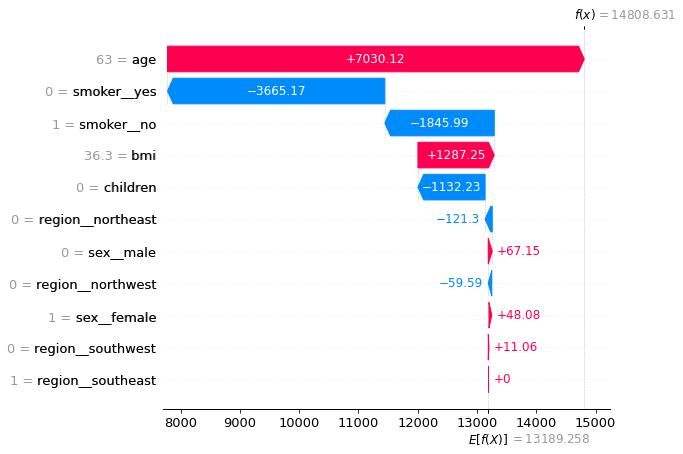

In [16]:
shap.plots.waterfall(gbm_shap_values[idx], max_display=14, show=False)
plt.show()

#### Force plots ("Global")

The force plots in the SHAP package can output both local and "global" interpretation graphs. While it does not provide a global explanation in the form of an equation like in our GLMs, it does give us a model-level view of the results to work with. This is done by stacking and sorting all the SHAP values for all predictions into 1 plot as shown below. 

While both axes can be customized from the combo box, by default, the Y-axis shows the output value of the model, while the X-axis plots all the samples in the dataset sorted by similarity (I personally like sorting it by output value). By hovering over an area of the graph, we can get a quick summary of the significant rating factors that are driving the modelled costs up (in red) or down (in blue). 

Just at a high level we can observe that the model has put a lot of emphasis on the state of smoking and age, which is in line with high BMIs have an interaction effect with smoking, accounting for many of the higher claim predictions.

In [17]:
# Static image used for article in the event that init.js() does not run

Image(url="img/shap_waterfall.png")

In [18]:
shap.initjs()
shap.force_plot(gbm_explainer.expected_value[0], gbm_shap_values.values, shap_df)

#### SHAP Dependency plots ("Global")

The SHAP dependency plot is a very simple graph that shows how the SHAP contributions differ for different values of the feature (BMI in this case). This is similar to a Partial Dependency Plot (PDP) which visualizes the marginal effect of a feature towards the model outcome by plotting out the average model predictions against different values of that feature. The SHAP dependency plots do not average the outcomes and show the variances on the y-axis. Here, we can clearly see an interaction effect between BMI values and the smoking state of the policyholder.

We see that the pink data points (non-smokers) have a more gradual slope for BMI contributions in contrast to the blue points (smokers), where the SHAP contributions jump significantly at the BMI=~30 point, which is in line with what we could guess from the previous force plot output above.

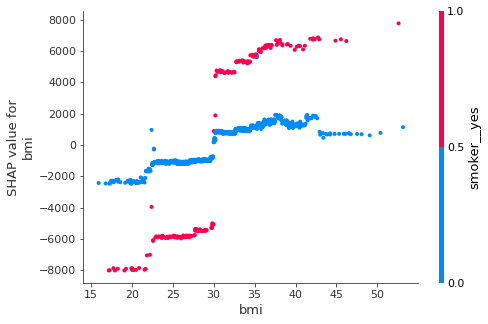

In [19]:
shap.dependence_plot(feature, gbm_shap_values.values, shap_df)

## SHAP vs LIME?

Now that we've seen some of the functionality available to us in the Python SHAP framework (available in R as well), it only makes sense to compare its advantages and disadvantages to another popular framework like LIME, which also utilizes the idea of explanation model for local interpretation using some form of linear approximation. Note that this list is non-exhaustive and only includes the most obvious/popular ones.

**Advantages**:
- SHAP provides a complete explanation between the global average and the model output for a particular explanation, whereas LIME's model may not, depending on the fit of the localized linear regression, this means that SHAP is more legally/professionally compliant than other methods.
- SHAP values are fairly distributed among the features whereas LIME does not guarantee this.
- SHAP has the backing of a long-standing and well understood economic theory. The underlying axioms and properties give SHAP a good foundation of why it should work, whereas LIME relies on the assumption of linearity locally.

**Disadvantages**:
- Only approximate SHAP values are feasible most of the time, the power set of models to compute exact solutions are very computationally expensive. Just imagine computing $2^{20}$ models on a small-sized dataset.
- SHAP values can easily be misinterpreted. By removing the feature for a particular observation, we do not get an outcome of the prediction less the SHAP value of that feature.  This also means that SHAP values cannot make predictions for changes in the input whereas results from LIME allows statements like: "_If this policyholder's BMI increased by 1, we can expect the modelled claims cost to increase by ~$500._"

## Afterward

As data becomes increasingly available and insurance products continue to get more complex, the use of more robust models to handles these interactions will be inevitable for many prediction tasks across the whole insurance value chain, not just for claims modelling and fraud detection.

Validation frameworks like SHAP and LIME seem to be a big step in the direction of model-agnostic-additive explanations. While article gives the reader a gentle and practical introduction to the idea and implementation behind SHAP, note that the theory and mathematics are a little more involved. If you are interested in deep diving into the details, there are a few links below to get you started.


- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
- [SHAP framework Github Repository](https://github.com/slundberg/shap)